# Classification of Twitter Narratives

### Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

## Extract and pre-process data

In [2]:
people = ['gdhande', 'Munesh', 'nivedita', 'Shweta', 'Swapnanil', 'Sharath']
dfs = []

In [3]:
for i,person in enumerate(people):
    df = pd.read_csv(f'data/s{i+1}.csv')
    df = df.rename(columns={'original_tweet': 'feature', f'annotations.{person}.supernarrative_1' : 'label'})
    df['label'] = df['label'].fillna('None')
    #df['label'] = pd.factorize(df['label'])[0]
    df = df[['feature', 'label']]
    dfs.append(df)

df = pd.concat(dfs,ignore_index=False)

In [4]:
X_train = df['feature']
y_train = df['label']


df_test = pd.read_csv('data/test.csv',encoding='latin1')
X_test = df_test['original_tweet']
y_test = df_test['group_annotator_supernarrative_1'].fillna('None')

## Hyperparameter Tuning

In [5]:
# Define classifiers
svm_clf = SVC()
mlp_clf = MLPClassifier(max_iter=1000)

# Set pipeline
svm_pipeline = make_pipeline(CountVectorizer(),TfidfTransformer(), svm_clf)
mlp_pipeline = make_pipeline(CountVectorizer(),TfidfTransformer(), mlp_clf)

# Define stacking classifier
estimators = [
    ('svm', make_pipeline(CountVectorizer(),TfidfTransformer(), SVC())),
    ('mlp', make_pipeline(CountVectorizer(),TfidfTransformer(), MLPClassifier(max_iter=1000)))
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [6]:

# Define parameter grids
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [0.1, 1, 10]
}

param_grid_mlp = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01]
}

param_grid_stacking = {
    'final_estimator__C': [0.1, 1, 10],
    'final_estimator__penalty': ['l1', 'l2'],
    'stack_method': ['auto', 'predict_proba']
}


In [7]:
# Perform grid search
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5)
grid_search_mlp = GridSearchCV(mlp_pipeline, param_grid_mlp, cv=5)
grid_search_stacking = GridSearchCV(stacking_clf, param_grid_stacking, cv=5)

In [8]:
# Fit the models
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('tfidftransformer', TfidfTransformer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf']})

In [9]:
grid_search_mlp.fit(X_train, y_train)

In [22]:
grid_search_stacking.fit(X_train, y_train)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:46

In [ ]:
# Predict and evaluate with classification report - write to CSV

y_pred_svm = grid_search_svm.predict(X_test)
y_pred_mlp = grid_search_mlp.predict(X_test)
y_pred_stacking = grid_search_stacking.predict(X_test)

print('SVM')
print(classification_report(y_test, y_pred_svm))
print('MLP')
print(classification_report(y_test, y_pred_mlp))
print('Stacking')
#print(classification_report(y_test, y_pred_stacking))

# Write to CSV
pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose().to_csv('perf_reports\svm.csv')
pd.DataFrame(classification_report(y_test, y_pred_mlp, output_dict=True)).transpose().to_csv('perf_reports\mlp.csv')
pd.DataFrame(classification_report(y_test, y_pred_stacking, output_dict=True)).transpose().to_csv('perf_reports\stacking.csv')


# Confusion matrix as PNGs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.close()

plot_confusion_matrix(y_test, y_pred_svm, 'imgs\svm_cm.png')
plot_confusion_matrix(y_test, y_pred_mlp, 'imgs\mlp_cm.png')
plot_confusion_matrix(y_test, y_pred_stacking, 'imgs\stack_cm.png')

SVM
                                 precision    recall  f1-score   support

                        Anti-EU       0.00      0.00      0.00        10
                    Anti-Elites       0.00      0.00      0.00         3
  Distrust in democratic system       0.00      0.00      0.00         9
       Distrust in institutions       0.38      0.10      0.15        31
              Ethnicity-related       0.00      0.00      0.00         2
                 Gender-related       0.00      0.00      0.00         3
                    Geopolitics       0.00      0.00      0.00         5
              Migration-related       0.00      0.00      0.00         2
                           None       0.44      0.88      0.59        67
Political hate and polarisation       0.43      0.34      0.38        47
               Religion-related       0.00      0.00      0.00         1

                       accuracy                           0.43       180
                      macro avg       0.11   

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Binary Chaining

In [25]:
# Define the chaining process
def chain_models(X_train, y_train):
    models = []

    labels = y_train.unique()
    for label in labels:
        # Filter data for the current label pair
        y_train_binary = (y_train == label).astype(int)

        # Define and fit the model
        model = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=1000)),
            ('clf', LogisticRegression())
        ])
        model.fit(X_train, y_train_binary)
        models.append(model)

    return models

In [26]:
def chain_predictions(models, X_test, threshold, labels):
    predictions = []

    for model in models:
        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        predictions.append(y_pred_prob)

    # Chaining predictions
    for i, prob in enumerate(predictions):
        if any(prob >= threshold):
            return labels[i]  # Return the label once the threshold is crossed

    return None  # Return None if no threshold is crossed by any model

In [27]:
# Get chained predictions
models_ = chain_models(X_train, y_train)

In [28]:
# Threshold for classification
labels = y_train.unique()
threshold = 0.2
predicted_label = chain_predictions(models_, X_test, threshold,labels)
print("Predicted Label:", predicted_label)

Predicted Label: Political hate and polarisation


In [29]:
predicted_labels = []   
for i in range(len(X_test)):
    predicted_label = chain_predictions(models_, X_test.iloc[i:i+1], threshold, labels)
    predicted_labels.append(predicted_label)

In [ ]:
#export classification report
report = classification_report(y_test, predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('perf_reports/binary_chain.csv')

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

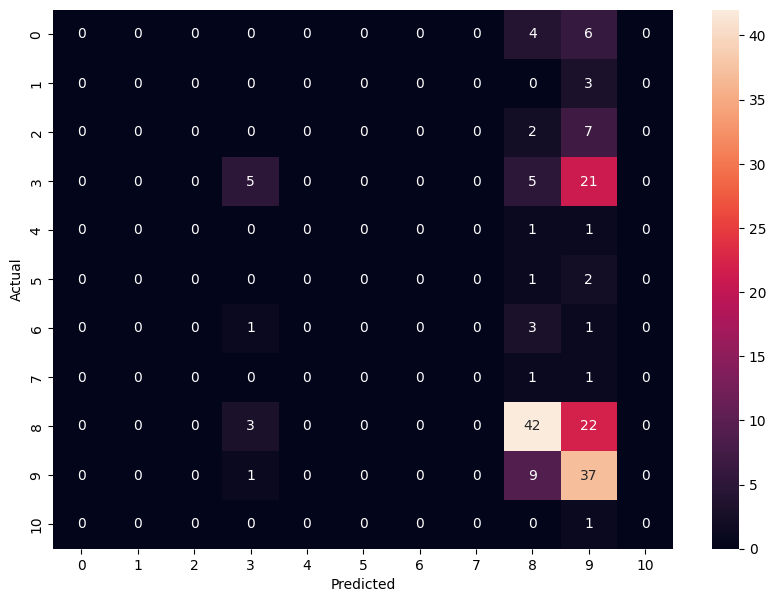

In [ ]:
#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('imgs/binary_chain.png')

## Robert Tuning

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#X_train_list = X_train.tolist()
#train_inputs = tokenizer(X_train_list, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH, return_tensors="pt")

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.feature
        self.targets = self.data.label.values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_data,test_data = train_test_split(df, test_size=0.2, random_state=42)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

print(type(test_data))


training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

In [ ]:
train_data['label'].values[1]

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)